In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import mysql.connector
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import scipy.stats as stats

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# instanciamento da conexão com o banco de dados do MySQL e do ponteiro/cursor

cnx = mysql.connector.connect(user = 'adm', password = 'adm123',
                             host = '127.0.0.1')
cursor = cnx.cursor(buffered = True)
cursor.execute ('USE prodserv1')

#### 4.7. Obtenção dos dados
Com os dados obtidos e devidamente estruturados no banco, é possível realizar as consultas necessárias para as análises.<br>

Primeiramente serão feitas análises sobre os projetos. Os dados serão obtidos do banco de dados de forma já agrupada através de uma consulta e carregada em um dataframe Pandas. Aos dados nativos dos projetos serão agregados os dados agrupados de horas de trabalho efetivamente empregadas por cada uma dos cargos de funcionários (ARQ, EST, PRO).

In [4]:
# Instrução SQL para obter tabela com dados agrupados de projetos e tempos de execução.

sql1 ='\
    WITH\
    tempos AS\
    (\
    SELECT\
        u.id_projeto, SUM(u.duracao) AS hs_exec, ps.cargo\
    FROM\
        uso_tempo AS u\
            INNER JOIN\
        pessoas AS ps ON u.id_pessoa = ps.id_pessoa\
    GROUP BY u.id_projeto, ps.cargo\
    ORDER BY 1\
    ),\
    \
    hs_arq AS\
    (SELECT t.id_projeto, t.hs_exec FROM tempos AS t WHERE t.cargo = "ARQ"),\
    \
    hs_est AS\
    (SELECT t.id_projeto, t.hs_exec FROM tempos AS t WHERE t.cargo = "EST"),\
    \
    hs_pro AS\
    (SELECT t.id_projeto, t.hs_exec FROM tempos AS t WHERE t.cargo = "PRO")\
    \
    SELECT\
        pr.*, hs_arq.hs_exec AS hs_exec_arq, hs_est.hs_exec AS hs_exec_est, hs_pro.hs_exec AS hs_exec_pro\
    FROM\
        projetos as pr\
            LEFT JOIN hs_arq ON pr.id_projeto = hs_arq.id_projeto\
            LEFT JOIN hs_est ON pr.id_projeto = hs_est.id_projeto\
            LEFT JOIN hs_pro ON pr.id_projeto = hs_pro.id_projeto;'

sql2 = '\
    SELECT cod_pessoa, id_pessoa FROM pessoas;'

In [5]:
# execução da instrução a captura dos dados para um Dataframe

cursor.execute (sql1)
colunas = cursor.column_names
dados = cursor.fetchall()
df_proj = pd.DataFrame(data = dados, columns = colunas)
df_proj.drop(columns = 'nome_projeto', inplace = True)

cursor.execute (sql2)
colunas = cursor.column_names
dados = cursor.fetchall()
df_pessoas = pd.DataFrame(data = dados, columns = colunas)


#### 4.8. Preprocessamento
Com os dados obtidos e devidamente estruturados no banco, é possível realizar as consultas necessárias para as análises.<br>

Primeiramente serão feitas análises sobre os projetos. Os dados serão obtidos do banco de dados de forma já agrupada através de uma consulta e carregada em um dataframe Pandas. Aos dados nativos dos projetos serão agregados os dados agrupados de horas de trabalho efetivamente empregadas por cada uma dos cargos de funcionários (ARQ, EST, PRO).

In [6]:
# verificação da correta importação dos dados
df_proj.sample(5)

,id_projeto,area,tipo_cliente,responsavel,tipologia,projeto_arq,projeto_int,projeto_outros,reforma,gerenciamento,complexidade,hs_estim_arq,hs_estim_est,hs_estim_pro,percent_concluido,ativo,hs_exec_arq,hs_exec_est,hs_exec_pro
29,0000-33,None,None,None,None,None,None,None,None,S,NaN,None,None,None,None,None,471.90,148.00,12.00
18,0000-22,None,None,None,None,None,None,None,None,N,NaN,None,None,None,None,None,2.25,4.00,32.25
25,0000-29,None,None,None,None,None,None,None,None,N,NaN,None,None,None,None,None,223.75,149.00,None
63,2012-57,535.00,J,GRA,CP,S,S,S,S,S,3.0,85.00,90.00,95.00,1.00,N,426.50,129.25,171.50
160,2021-157,550.00,J,MIG,CP,S,N,S,N,N,2.0,100.00,0.00,0.00,1.00,N,119.61,None,None


In [7]:
df_proj.shape

(177, 19)

In [8]:
id_pessoas = df_pessoas.id_pessoa.to_list()
cod_pessoas = df_pessoas.cod_pessoa.to_list()
substituir = dict(zip(id_pessoas, cod_pessoas))

df_proj['id_responsavel'] = df_proj.responsavel.map(substituir)
df_proj.drop(columns = 'responsavel', inplace = True)

Serão removidos os dados que não interessam para as análises, como já citado, com identificador iniciando em "0000".<br>

In [9]:
idx_remover = df_proj.id_projeto[df_proj.id_projeto.str.startswith('0000')].index
df_proj.drop(idx_remover, inplace = True)

df_proj.reset_index(inplace = True, drop = True)

#### 4.8.1 Tratamento de colunas e tipos de dados

In [10]:
df_proj.dtypes

id_projeto            object
area                  object
tipo_cliente          object
tipologia             object
projeto_arq           object
projeto_int           object
projeto_outros        object
reforma               object
gerenciamento         object
complexidade         float64
hs_estim_arq          object
hs_estim_est          object
hs_estim_pro          object
percent_concluido     object
ativo                 object
hs_exec_arq           object
hs_exec_est           object
hs_exec_pro           object
id_responsavel        object
dtype: object

In [11]:
# tratamento de tipos de dados

cols_float = ['area', 'hs_estim_arq', 'hs_estim_est', 'hs_estim_pro',\
              'percent_concluido', 'hs_exec_arq', 'hs_exec_est', 'hs_exec_pro']

df_proj[cols_float] = df_proj[cols_float].astype('float64')

# dados ausentes de complexidade substituídos por zero para permitir transformação da coluna para o tipo inteiro.
df_proj['complexidade'] = df_proj['complexidade'].fillna(0)

df_proj.complexidade = df_proj.complexidade.astype('int')

In [12]:
df_proj.dtypes

id_projeto            object
area                 float64
tipo_cliente          object
tipologia             object
projeto_arq           object
projeto_int           object
projeto_outros        object
reforma               object
gerenciamento         object
complexidade           int32
hs_estim_arq         float64
hs_estim_est         float64
hs_estim_pro         float64
percent_concluido    float64
ativo                 object
hs_exec_arq          float64
hs_exec_est          float64
hs_exec_pro          float64
id_responsavel        object
dtype: object

#### 4.8.1 Tratamento de colunas, tipos de dados e entradas nulas
Na verificação de dados ausentes e nulos há registros nos quais todos os três campos de horas estimadas estão zerados.
Correspondem aos projetos que originalmente não dispunham destes dados em planilhas orçamentárias.
Além destes, há registros de horas executadas que são zeradas de fato nas planilhas. Estas serão substituídas por zero
para permitir cálculos de ponderação de horas executadas.

In [13]:
df_proj.isnull().sum()

id_projeto            0
area                  0
tipo_cliente          0
tipologia             0
projeto_arq           0
projeto_int           0
projeto_outros        0
reforma               0
gerenciamento         0
complexidade          0
hs_estim_arq         25
hs_estim_est         25
hs_estim_pro         25
percent_concluido     0
ativo                 0
hs_exec_arq           0
hs_exec_est          36
hs_exec_pro          92
id_responsavel        0
dtype: int64

In [14]:
df_proj['hs_exec_arq'] = df_proj['hs_exec_arq'].fillna(0)
df_proj['hs_exec_est'] = df_proj['hs_exec_est'].fillna(0)
df_proj['hs_exec_pro'] = df_proj['hs_exec_pro'].fillna(0)

In [15]:
df_proj.isnull().sum()

id_projeto            0
area                  0
tipo_cliente          0
tipologia             0
projeto_arq           0
projeto_int           0
projeto_outros        0
reforma               0
gerenciamento         0
complexidade          0
hs_estim_arq         25
hs_estim_est         25
hs_estim_pro         25
percent_concluido     0
ativo                 0
hs_exec_arq           0
hs_exec_est           0
hs_exec_pro           0
id_responsavel        0
dtype: int64

#### 4.8.2 Novas variáveis

Para a mensuração do tempo gasto nos projetos, serão somadas as horas de trabalho de todos os profissionais. No entanto, as horas de trabalho das pessoas de diferentes cargos tem pesos diferentes no que se refere aos custos. Serão 4 novas variáveis. Além da soma simples das horas estimadas e executadas efetivamente, serão calculadas as somas ponderadas, considerando os pesos específicos de cada profissional.<br>

À soma ponderada das horas executadas ainda será aplicado o percentual de conclusão do projeto para normalizar esta soma e permitir a comparação com as horas estimadas. Isto é necessário pois há situações nas quais o contrato encerrou-se antes da conclusão do escopo previsto para o projeto ou o contrato pode estar ainda em andamento (o que permite identificar durante a execução ainda os projetos que tendem a desviar do orçamento).<br>

Com estes parâmetros em vista serão calculados o desvio absoluto em horas e o desvio percentual.<br>

Outra variável que será gerada para as primeiras análises será a quantidade de disciplinas envolvidas no projeto. O valor poderá variar de 1 a 3, conforme façam parte do contrato as disciplinas de Projeto Arquitetônico, Projeto de Interiores e Projeto Outros. Isto pode dar uma medida de esforço envolvido além da complexidade.<br>

Será criada ainda uma variável indicativa de Lucro ou Prejuízo para o projeto, conforme tenha permanecido abaixo ou acima das estimativas originais de tempo.

In [16]:
# definição da função para criação das novas variáveis

def novas_variaveis (df_proj):
    peso_arq, peso_est, peso_pro = 1, 0.1, 0.3

    df_proj['hs_estim_pond'] = df_proj.hs_estim_arq * peso_arq + \
                               df_proj.hs_estim_est * peso_est + \
                               df_proj.hs_estim_pro * peso_pro

    df_proj['hs_exec_pond']  = (df_proj.hs_exec_arq * peso_arq + \
                               df_proj.hs_exec_est * peso_est + \
                               df_proj.hs_exec_pro * peso_pro)

    df_proj['hs_estim_total'] = df_proj.hs_estim_arq + df_proj.hs_estim_est + df_proj.hs_estim_pro

    df_proj['hs_exec_total'] = df_proj.hs_exec_arq + df_proj.hs_exec_est + df_proj.hs_exec_pro

    df_proj['qt_disciplinas'] =\
        df_proj[['projeto_arq','projeto_int','projeto_outros']].map(lambda x: 0 if x=='N' else 1).sum(axis = 1)

    df_proj['desvio_abs'] = df_proj.hs_exec_pond - (df_proj.hs_estim_pond * df_proj.percent_concluido)

    df_proj['desvio'] = df_proj.desvio_abs / (df_proj.hs_estim_pond * df_proj.percent_concluido)

    df_proj['resultado'] = df_proj[['desvio_abs']].map(lambda x: 'L' if x <= 0 else 'P' if x > 0 else None)
    
    return df_proj

In [17]:
df_proj = novas_variaveis(df_proj)

#### 4.9. Análise Exploratória

In [18]:
# separação das variáveis em dois grupos: qualitativas e quantitativas

vars_quali = df_proj.select_dtypes(include = 'object').columns.to_list()
vars_quali.remove('id_projeto')
vars_quali.remove('ativo')

vars_quant = ['area', 'complexidade', 'hs_estim_pond', 'hs_exec_pond', 'desvio', 'desvio_abs',
       'hs_estim_total', 'hs_exec_total', 'qt_disciplinas']

<br>

**4.9.1. Familiarização com a variáveis qualitativas**

In [19]:
sns.set_theme(style = 'whitegrid', palette = 'pastel')

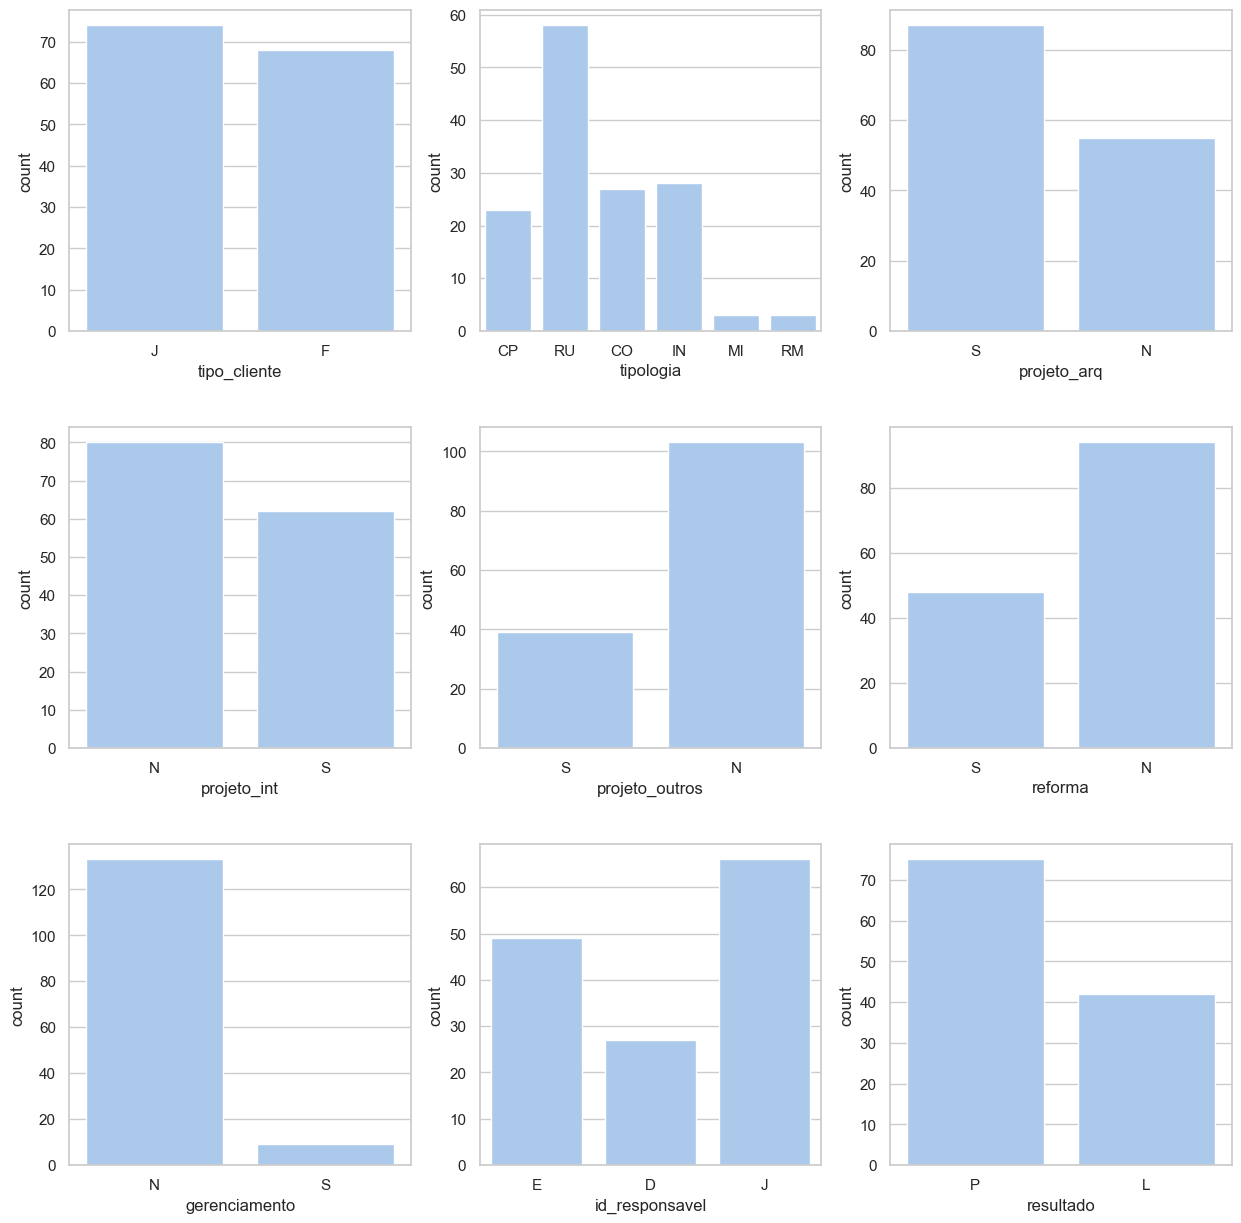

In [20]:
f, axs = plt.subplots (nrows = int(len(vars_quali)/3), ncols = 3, figsize = (15,15))
i = 0
for v in vars_quali:
    sns.countplot(df_proj, x = v, ax = axs.flat[i])
    i += 1
plt.subplots_adjust(hspace = 0.3)

Há um equilíbrio entre clientes pessoas físicas e jurídicas; uma predominância de tipologia Residencial Unifamiliar (RU) e baixa quantidade de tipologias MI (Misto) e RM (Residencial Multifamiliar); predominância dos projetos que incluem projeto arquitetônico, sem projeto de interiores, em obras novas (não reforma) e sem gerenciamento de obra; a pessoa responsável por maior número de projetos é "J" o dobro de "D".<br>

Já chama atenção também o maior número de projetos que excederam a quantidade de horas estimadas, com provável prejuízo financeiro.

<br><br>
**4.9.2. Familiarização com a variáveis qualitativas:**

In [21]:
df_proj[vars_quant].describe()

,area,complexidade,hs_estim_pond,hs_exec_pond,desvio,desvio_abs,hs_estim_total,hs_exec_total,qt_disciplinas
count,142.000000,142.000000,117.000000,142.000000,117.000000,117.000000,117.000000,142.000000,142.000000
mean,656.771056,2.014085,88.153846,103.616197,0.558707,31.442051,141.132479,177.728380,1.323944
std,1352.701290,0.673573,69.090049,102.864130,1.183817,70.163606,109.786929,150.789083,0.636360
min,6.000000,1.000000,8.000000,2.250000,-0.887753,-96.750000,8.000000,2.250000,0.000000
25%,100.000000,2.000000,36.500000,30.612500,-0.136222,-4.650000,63.000000,56.225000,1.000000
50%,218.235000,2.000000,81.200000,66.290000,0.312500,12.000000,120.000000,139.000000,1.000000
75%,533.000000,2.000000,107.600000,127.362500,0.766667,53.925000,185.000000,256.937500,2.000000
max,10812.810000,3.000000,370.000000,490.875000,6.262887,368.375000,550.000000,782.000000,3.000000


Os dados parece possuem grande variância e ter distribuições assimétricas. Vamos plotá-las para entender melhor.

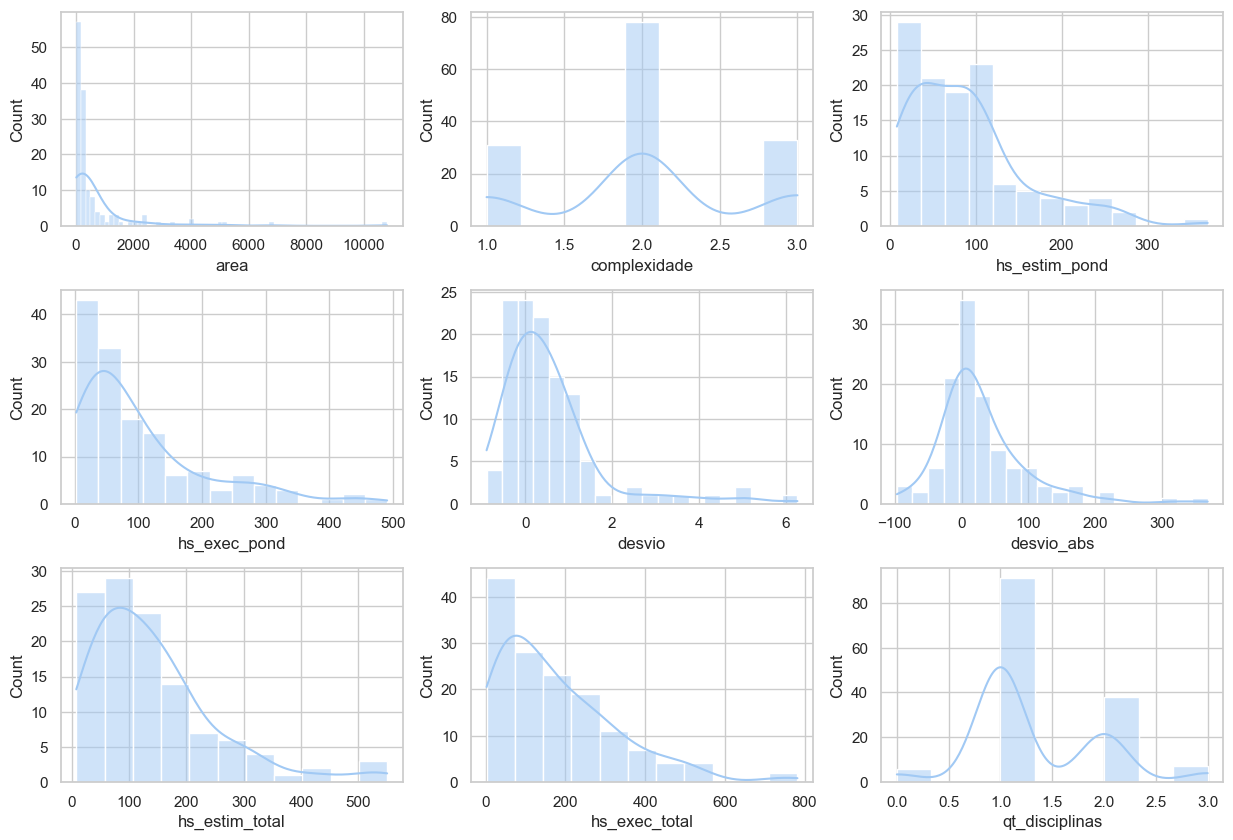

In [22]:
f, axs = plt.subplots (nrows = int(len(vars_quant)/3), ncols = 3, figsize = (15,10))
i = 0
for v in vars_quant:
    sns.histplot(df_proj, x = v, ax = axs.flat[i], kde=True)
    i += 1
plt.subplots_adjust(hspace = 0.3)

A distribuição da variável `area` apresenta uma assimetria à esquerda e mostra uma grande variedade de perfis de projetos quanto a este aspecto, ou seja, uma grande quantidade de projetos com áreas construídas menores e pequenas quantidades de projetos com áreas maiores. Distribuições semelhantes aparecem nas variáveis relacionadas a horas (estimadas e executadas). <br>

Chamam atenção as variáveis `desvio` e `desvio_abs`, sendo esta última com uma distribuição próxima a uma normal. `desvio` é um índice e também apresenta uma assimetria à esquerda. Isto indica uma grande quantidade de projetos com pouco desvio proporcional de horas (mas ainda assim em excesso) e poucos projetos com grandes desvios proporcionais. <br>

<br><br>
**4.9.3. Identificação e tratamento de valores discrepantes / outliers:**

As variáveis `desvio` e `desvio_abs` são indicadores chave para as análises e apresentam valores discrepantes nas distribuições os quais vale à pena investigar.

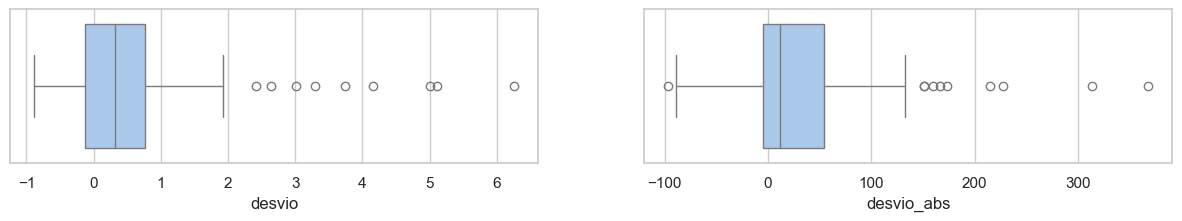

In [23]:
# plota gráficos tipo boxplot das variáveis chave para melhor identificar os outliers

cols_out = ['desvio','desvio_abs']

f, axs = plt.subplots (nrows = 1, ncols = 2, figsize = (15,2))
i = 0
for v in cols_out:
    sns.boxplot(df_proj, x = v, ax = axs.flat[i], orient = 'h')
    i += 1
plt.subplots_adjust(hspace = 0.3)

In [24]:
'''Função que analisa uma variável quantitativa e classifica como outlier ou não, acrescentando uma nova coluna
ao dataframe com esta identificação.
O critério para esta classificação é a localização dos valores além dos limites superior ou inferior da série de dados,
definidos como o 1,5 x o intervalo interquartil abaixo do 25o. percentil ou acima do 75o. percentil.'''

def detecta_outlier(df, variavel):
    q1 = df[variavel].quantile(0.25)
    q3 = df[variavel].quantile(0.75)
    limite_inf = q1 - (q3 - q1) * 1.5
    limite_sup = q3 + (q3 - q1) * 1.5
    df[variavel + '_out'] = df[variavel].apply(lambda x: True if (x < limite_inf or x > limite_sup) else False)

In [25]:
# chama a função definida para identificar os outliers conforme as variáveis solicitadas

detecta_outlier (df_proj, 'desvio_abs')
detecta_outlier (df_proj, 'desvio')

In [26]:
# filtra os projetos classificados como outliers conforme uma ou as duas variáveis

cols_filtro = ['id_projeto','gerenciamento','hs_estim_pond','hs_exec_pond','desvio_abs','desvio',\
               'desvio_abs_out', 'desvio_out','percent_concluido']

df_out = df_proj[(df_proj.desvio_out == True) | (df_proj.desvio_abs_out == True)][cols_filtro].\
        sort_values(by = ['desvio'], ascending = False)

df_out

,id_projeto,gerenciamento,hs_estim_pond,hs_exec_pond,desvio_abs,desvio,desvio_abs_out,desvio_out,percent_concluido
36,2013-02,S,9.7,70.450,60.750,6.262887,False,True,1.00
75,2015-19,N,22.0,134.600,112.600,5.118182,False,True,1.00
13,2012-26,N,9.1,54.650,45.550,5.005495,False,True,1.00
68,2014-50,S,51.5,266.025,214.525,4.165534,True,True,1.00
89,2017-57,N,24.0,113.625,89.625,3.734375,False,True,1.00
115,2020-138,N,20.4,87.550,67.150,3.291667,False,True,1.00
28,2012-57,S,122.5,490.875,368.375,3.007143,True,True,1.00
78,2015-24,N,86.0,313.380,227.380,2.643953,True,True,1.00
69,2014-52,N,260.0,444.050,314.050,2.415769,True,True,0.50
122,2020-154,N,100.0,251.500,151.500,1.515000,True,False,1.00


In [27]:
df_out.shape

(15, 9)

Foram identificados 15 outliers e feita uma análise individual de cada caso. Temos 9 situações que tratam de inconsistência nos dados e que podem e devem ser tratadas, como descrito a seguir:<br>

- Inconsistência da entrada de dados:<br>

Os projetos com os id´s 2013-02 / 2014-50 / 2012-57 são casos nos quais o escopo trata de projeto e gerenciamento de obra mas em cujas planilhas orçamentárias foram consideradas somente as horas de projeto. A precificação do gerenciamento naquele momento era feita com outra metodologia (percentual de valor administrado, não por estimativa de horas).<br>

O projeto 2015-23 passou por situação parecida, com aumento de escopo no decorrer do desenvolvimento, sem atualização da planilha estimativa e sem possibilidade de separação do escopo original para comparação.><br>

Nestes casos não é possível diferenciar as horas de projeto e de gerenciamento, portanto não faz sentido calcular desvios. Então, o valor de horas estimadas será setado para `None`, para que seja desconsiderado.

In [28]:
linhas = df_proj[df_proj.id_projeto.isin(['2013-02','2014-50','2012-57','2015-23'])].index
df_proj.loc[linhas.values,['hs_estim_pond','hs_estim_total','hs_estim_arq','hs_estim_pro','hs_estim_est']] = None

* Preenchimento incorreto da planilha orçamentária:<br>

O projeto 2012-26 era subdividido em 3 subprojetos. Cada um destes subprojetos possuía uma planilha orçamentária específica, porém a planilha de ontem foram extraídos os dados era de somente um dos subprojetos. Como os registros de horas foram feitos sem distinção, os dados de horas estimadas serão reinseridos manualmente.<br>

In [29]:
linha = df_proj[df_proj.id_projeto == '2012-26'].index[0]
df_proj.at[linha,'hs_estim_arq'] = 26.5
df_proj.at[linha,'hs_estim_pro'] = 44
df_proj.at[linha,'hs_estim_est'] = 18

* Projetos com compensação de horas:<br>

Os projetos 2015-24 / 2020-154 / 2022-181 / 2021-119 foram projetos desenvolvidos total ou parcialmente durante período de migração para uma nova metodologia e ferramenta de trabalho, quando era sabido que haveria atrasos nas entregas por conta da curva de aprendizado da equipe. Caso a caso, será arbitrado um percentual de horas executadas que serão incorporadas como Treinamento/Capacitação.<br>

Com outros projetos (não outliers) com os quais ocorreu a mesma situação, será aplicada redução também.

In [30]:
dic_reducao = {'2015-24': 0.15, '2020-154': 0.2, '2021-119': 0.4, '2020-149': 0.5,\
               '2021-155': 0.2, '2021-157': 0.5, '2022-177': 0.2, '2022-181': 0.5, '2022-188': 0.25}

for c, v in dic_reducao.items():
    linha = df_proj[df_proj.id_projeto == c].index[0]
    for col_hs in ['hs_exec_arq', 'hs_exec_pro', 'hs_exec_est']:
        horas = df_proj.at[linha, col_hs]
        horas_reduzidas = horas * (1 - v)
        df_proj.at[linha, col_hs] = horas_reduzidas

Após os tratamentos dos outliers, as horas ponderadas e os desvios serão recalculados, assim como os outliers, com nova chamada das funções correspondentes.

In [31]:
df_proj = novas_variaveis(df_proj)
detecta_outlier (df_proj, 'desvio_abs')
detecta_outlier (df_proj, 'desvio')

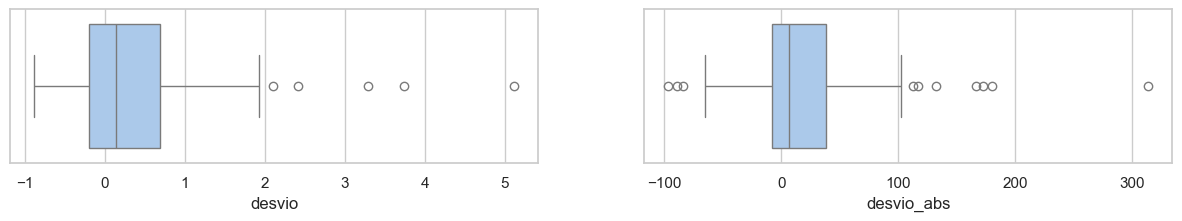

In [32]:
# novamente são plotadas os valores dos desvios

cols_out = ['desvio','desvio_abs']

f, axs = plt.subplots (nrows = 1, ncols = 2, figsize = (15,2))
i = 0
for v in cols_out:
    sns.boxplot(df_proj, x = v, ax = axs.flat[i], orient = 'h')
    i += 1
plt.subplots_adjust(hspace = 0.3)

In [33]:
# visualização dos outliers após o tratamento

cols_filtro = ['id_projeto','gerenciamento','hs_estim_pond','hs_exec_pond','desvio_abs','desvio',\
               'desvio_abs_out', 'desvio_out','percent_concluido']

df_out = df_proj[(df_proj.desvio_out == True) | (df_proj.desvio_abs_out == True)][cols_filtro].\
        sort_values(by = ['desvio'], ascending = False)

df_out

,id_projeto,gerenciamento,hs_estim_pond,hs_exec_pond,desvio_abs,desvio,desvio_abs_out,desvio_out,percent_concluido
75,2015-19,N,22.0,134.600,112.600,5.118182,True,True,1.0
89,2017-57,N,24.0,113.625,89.625,3.734375,False,True,1.0
115,2020-138,N,20.4,87.550,67.150,3.291667,False,True,1.0
69,2014-52,N,260.0,444.050,314.050,2.415769,True,True,0.5
78,2015-24,N,86.0,266.373,180.373,2.097360,True,True,1.0
120,2020-151,N,115.0,201.500,132.500,1.920290,True,False,0.6
20,2012-35,N,106.0,223.150,117.150,1.105189,True,False,1.0
67,2014-27,S,165.5,338.350,172.850,1.044411,True,False,1.0
72,2015-12,N,250.0,416.300,166.300,0.665200,True,False,1.0
96,2018-104,N,370.0,273.250,-96.750,-0.261486,True,False,1.0


Após o tratamento dos dados ainda temos outliers, mas que fazem parte dos dados a serem analisados e serão mantidos.

**Chamada para ação !** <br>
Deve ser verificado de imediato o que levou os projetos acima a terem os desvios apresentados, principalmente naqueles que foram classificados como outliers tanto em termos absolutos como relativos, pois a chance de que tenham causado prejuízo significativo (ou lucro no caso dos três últimos) ao negócio.

**4.9.4. Analisando variáveis de interesse**

A parte do escopo deste projeto que se refere a análises descritivas, como elencado no item 2, assim como as respectivas abordagens, estão descritos abaixo:

- _Subsidiar a avaliação do resultado financeiro dos projetos:_ o resultado financeiro do projeto está fortemente vinculado à adequação da quantidade de horas utilizadas no projeto à quantidade de horas estimadas. Esta relação é medida pelas variáveis `desvio_abs` (desvio absoluto em horas) e `desvio` (índice de desvio em relação ao estimado). A variável `resultado` classifica o projeto como potencial prejuízo ou lucro conforme o `desvio_abs` maior ou menor do que zero;


- _Identificar perfis de projetos que tendem a extrapolar estimativas de custo:_ realizar uma análise univariada das variáveis `resultado` e `desvio` estratificadas conforme as demais variáveis descritoras para observar diferenças no comportamento das variáveis de interesse que possam indicar características de projetos deficitários ou superavitários em termos de horas utilizadas.

**4.9.4.1. Análise da variável `resultado`**

In [34]:
# calcula a tabela de frequência simples para resultados

resultados = df_proj.resultado.value_counts() / df_proj[df_proj.resultado.notnull()].shape[0]
preju = resultados.P
lucro = resultados.L
print (f'Em {preju*100:.2f}% dos projetos houve excesso de horas')
print (f'Em {lucro*100:.2f}% dos projetos houve sobra de horas')

Em 58.41% dos projetos houve excesso de horas
Em 41.59% dos projetos houve sobra de horas


Vamos detalhar esta análise para entender como as demais variáveis influenciam no resultado final do projeto.

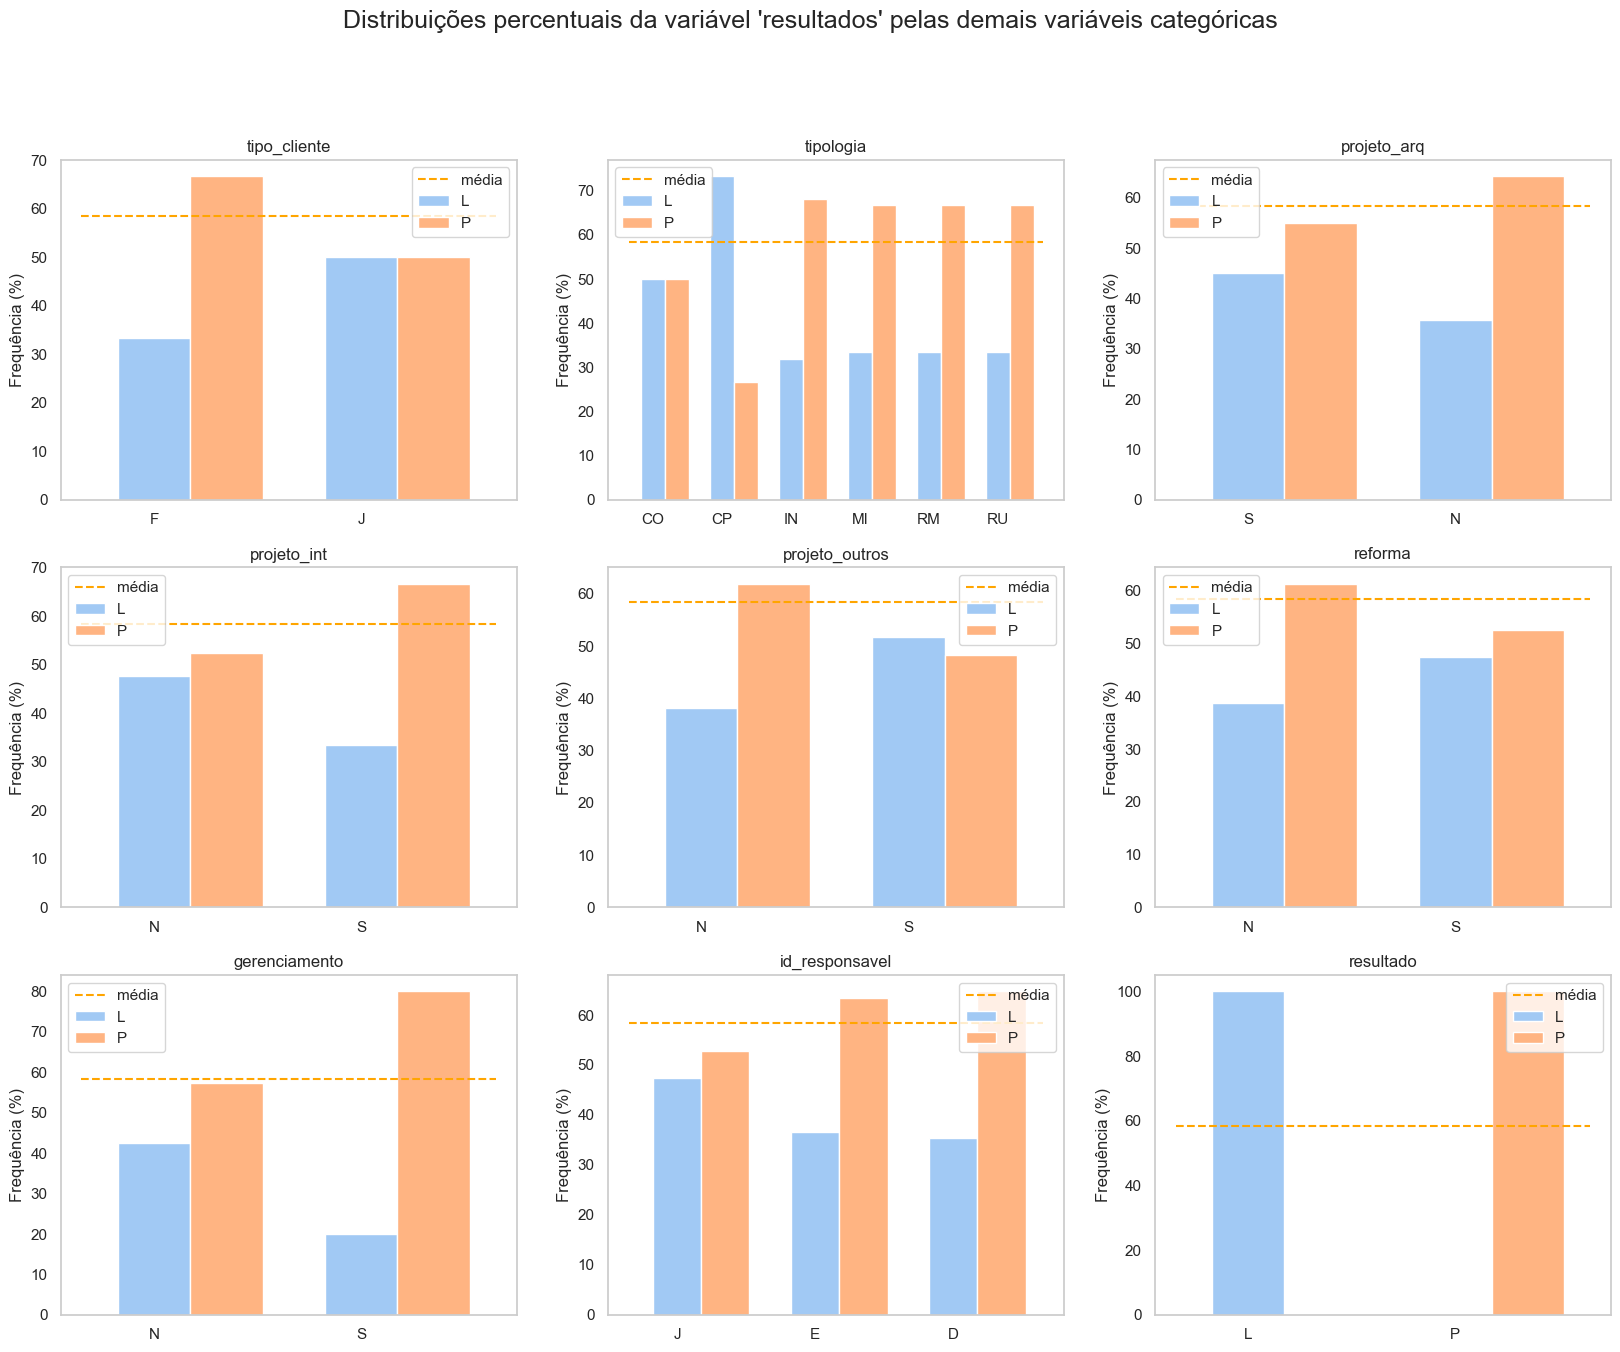

In [35]:
# Plotagem da contagem de projetos com excesso x sobra de horas (potencial lucro x prejuízo) conforme as demais categorias

n_col = 3
n_lin = int(len(vars_quali) / n_col)

fig, axs = plt.subplots(n_lin, n_col, figsize = (20,15))

idx_var = 0

for lin in np.arange(0, n_lin):
    
    for col in np.arange(0, n_col):
        
        var = vars_quali[idx_var]
        tab = df_proj[var].groupby(df_proj['resultado']).apply(lambda x: x.value_counts())
        tab = tab.unstack()
        tab = tab / tab.sum()*100
        labels = list(tab.columns)
        cats = {c: tab.loc[c,:] for c in list(tab.index)}
        n_cats = len(cats)

        x = np.arange(len(labels))
        width = 0.35
        rects = list(np.arange(n_cats))
        i = 0
        for c, v in cats.items():
            rects[i] = axs[lin, col].bar (x + i*width, v, width, label = c)
            i += 1

        axs[lin, col].set_xticklabels(labels) # legenda dos labels do eixo x
        axs[lin, col].set_xticks(x) #seta a posição dos labels
        
        # pltagem da uma linha indicando a frequência percentual geral dos projetos com excesso de horas
        # já obtida anteriormente, para comparação
        line = axs[lin, col].hlines (preju*100, 0-width, len(labels)-width,\
                                     label = 'média', color = 'orange', linestyle = 'dashed')
        
        axs[lin, col].set_ylabel('Frequência (%)') #legenda eixo y
        axs[lin, col].set_title(var) #titulo
        axs[lin, col].legend()
        axs[lin, col].grid(visible=False)
        
        idx_var += 1

plt.suptitle("Distribuições percentuais da variável 'resultados' pelas demais variáveis categóricas", fontsize = 18)
plt.show()

Obervando aos valores de frequências percentuais (laranja) em cada variável, em comparação com a frequência percentual geral, há diferenças que parecem ser significativas em alguns casos.<br>

Vamos medir o grau efetivo da associação entre as variáveis explicativas e a variável de interesse (`resultado`), todas categóricas.

In [36]:
# definição de uma função que calcula o grau de associação entre duas variáveis
# ela obtém uma tabela de contingências das variáveis informadas e utiliza a biblioteca scipy para obter
# os valores do qui-quadrado e o p-valor.

def calc_associacao(df, var_explica, var_interesse, nivel_signif):
    
    tab_contingencia = df[var_explica].groupby(df[var_interesse]).apply(lambda x: x.value_counts())
    tab_contingencia = tab_contingencia.unstack()
    chi2, p, dof, expected = chi2_contingency(tab_contingencia)
    valor_critico = stats.chi2.ppf(1 - nivel_signif, dof)
    
    return chi2, p

In [37]:
# iteração sobre a lista de variáveis qualitativas versus `resultado` e constrói um dataframe com os resultados do teste

associacoes = []
for v in vars_quali:
    chi2, p = calc_associacao(df_proj, v, 'resultado', 0.05)
    associacoes.append([chi2, p])
    
pd_associa = pd.DataFrame (data = associacoes, columns = ['chi2','p-valor'], index = vars_quali)
pd_associa.sort_values(by='p-valor')

,chi2,p-valor
tipologia,9.242364,0.099779
tipo_cliente,2.580327,0.108199
projeto_int,1.789557,0.180980
projeto_outros,1.135018,0.286708
projeto_arq,0.604768,0.436764
id_responsavel,1.431217,0.488895
reforma,0.468737,0.493569
gerenciamento,0.289418,0.590594
resultado,NaN,NaN


O p-valor calculado pode ser interpretado como a probabilidade de que as variações observadas nas tabelas de contingência em comparação com a distribuição geral ocorram por acaso. Ou seja, quanto menor o valor, mais forte é a associação entre as variáveis.<br>

Observamos na tabela gerada que apenas as variáveis `tipologia` e `tipo_cliente` possuem uma associação mais significativa, com p-valor próximo a 0,1. A variável `projeto_int` possui um p-valor de 0,18 e as demais acima 0,3.<br>

Apesar de os gráficos indicarem uma aparência de associação da de `resultado` com as demais variáveis, as únicas que apresentam alguma evidência mais sólida são as duas primeiras. Isto pode ser devido à baixa ocorrência em alguma categoria (`gerenciamento` é um exemplo), ou efetivamente à diferença absoluta pouco expressiva entre valores observados e esperados.<br>

A partir das observações, podemos afirmar que:

* tipo_cliente: projetos para pessoas físicas (F) tendem a ter excesso de horas<br>
* tipologia: Residencial Unifamiliar (RU) e Institucionais (I) tem o dobro da incidência de projetos com excesso de horas. Comerciais (CO) e Corporativos (CP) tendem a equilibrar ou minimizar este excesso.<br>

As duas variáveis possuem alguma relação, já que clientes tipo pessoa física estão geralmente ligados a tipologias RU (casas, apartamentos, etc), assim como os clientes pessoa jurídica estão mais relacionados às outras tipologias.<br>

Uma hipótese para esta diferença é que há menor objetividade na tomada de decisão com clientes PF, onde são tratados aspectos da vida pessoal, tomada de decisão difusa e pouca clareza nos objetivos do projeto, em comparação com pessoas jurídicas.<br>

**Ponto de atenção: validar a hipótese de pouca objetividade na tomada de decisão nos perfis indicados e levar este aspecto em conta na precificação e contratação, considerando, por exemplo, o tempo gasto com propostas a mais, e/ou previsão em contrato de revisões de valores no decorrer no processo.**<br>

* projeto_int: há maior incidência de excesso de horas quando projeto de interiores está presente no escopo.<br>

Aqui, a evidência de associação entre `projeto_int` e `resultado` é mais fraca. Ainda assim, é interessante observar ao longo do tempo, com mais dados coletados, se a associação se fortalece. Independente disto, cabe uma atenção especial na formulação de propostas nas quais esta disciplina esteja presente no escopo.<br>

**4.9.4.2. Análise da variável `desvio`**<br>

A variável analisada anteriormente apenas indica se houve ou não excesso de horas na execução dos projetos, independente da sua quantidade. Isto mostra apenas um quadro parcial da situação. Queremos saber a dimensão dos desvios e assim poder avaliar melhor se e como as características dos projetos afetam nos resultados dos projetos.<br>

In [38]:
# cálculo da soma do excesso de horas e o seu percentual em relação ao estimado
condicao = (df_proj['hs_estim_pond'].notna())

total_desvio = df_proj[condicao].desvio_abs.sum()
total_hs_estim = (df_proj[condicao].hs_estim_pond * df_proj[condicao].percent_concluido).sum()
desvio_total = total_desvio / total_hs_estim

print (f'Desvio total: {total_desvio:.2f} h')
print (f'Desvio total: { desvio_total * 100:.2f} %')

Desvio total: 2381.99 h
Desvio total: 28.32 %


No total foram empregadas 28% a mais de horas de trabalho do que o estimado nos projetos.<br>
É um percentual importante e representa potencial de minar a lucratividade do negócio.<br>

Vamos aprofundar a análise para entender como estão distribuídos estes desvios.

* **Distribuição dos desvios ao longo do tempo:**

Vamos procurar entender como os desvios aconteceram ao longo do tempo. Não é possível obter o dado instantâneo ao longo do desenvolvimento dos projetos sendo que apenas dispomos da informação global dos desvios. A ideia é calcular um desvio percentual geral de projetos a cada ano.<br>

Vamos verificar qual o tempo médio do ciclo de um projeto:

In [39]:
# obtenção da diferença de tempo em meses entre o primeiro e o último registro de tempo de cada projeto

sql = """
SELECT p.id_projeto, DATEDIFF(t.data_fim, t.data_inicio)/30 AS tempo_total_meses
    FROM projetos AS p
    LEFT JOIN 
        (SELECT id_projeto, MIN(data_registro) AS data_inicio, MAX(data_registro) AS data_fim
            FROM uso_tempo GROUP BY id_projeto) AS t
        ON p.id_projeto = t.id_projeto;
"""

cursor.execute (sql)
colunas = cursor.column_names
dados = cursor.fetchall()
df_ciclos = pd.DataFrame(data = dados, columns = colunas)
df_ciclos.tempo_total_meses = df_ciclos.tempo_total_meses.astype('float')

df_ciclos

,id_projeto,tempo_total_meses
0,0000-01,144.6000
1,0000-02,143.5667
2,0000-03,138.3667
3,0000-04,126.4333
4,0000-05,33.9000
...,...,...
172,2023-192,6.5667
173,2023-197,2.5667
174,2023-198,2.9667
175,300311,21.9000


In [40]:
# vamos cruzar com a tabela projeto com o método 'left' para obetermos dados somente dos projetos em análise

df_proj = df_proj.merge (df_ciclos, how = 'left', on = 'id_projeto')

In [41]:
print (f'Média de tempo de duração dos projetos em meses: {df_proj.tempo_total_meses.mean():.2f}')

Média de tempo de duração dos projetos em meses: 15.13


* Como em média os projetos duram 15 meses, faremos uma ponderação do desvio total de cada projeto para cada ano no qual ele esteve ativo

In [42]:
# consulta SQL para obter as horas de projeto por cargo e ano

sql = """
WITH
    tempos AS
    (
    SELECT
        u.id_projeto, SUM(u.duracao) AS hs_exec, ps.cargo, YEAR(u.data_registro) AS ano
    FROM
        uso_tempo AS u
            INNER JOIN
        pessoas AS ps ON u.id_pessoa = ps.id_pessoa
    GROUP BY u.id_projeto, ano, ps.cargo
    ORDER BY 1
    ),
    
    anos AS
    (
    SELECT
       id_projeto, YEAR(data_registro) AS ano
    FROM
        uso_tempo

    GROUP BY id_projeto, ano
    ORDER BY 1
    ),
    
    hs_arq AS
    (SELECT t.id_projeto, t.ano, t.hs_exec FROM tempos AS t WHERE t.cargo = "ARQ"),
    
    hs_est AS
    (SELECT t.id_projeto, t.ano, t.hs_exec FROM tempos AS t WHERE t.cargo = "EST"),
    
    hs_pro AS
    (SELECT t.id_projeto, t.ano, t.hs_exec FROM tempos AS t WHERE t.cargo = "PRO")
    
SELECT a.id_projeto, a.ano, hs_arq.hs_exec AS hs_exec_arq, hs_est.hs_exec AS hs_exec_est, hs_pro.hs_exec AS hs_exec_pro

    FROM anos as a
        LEFT JOIN hs_arq ON a.id_projeto = hs_arq.id_projeto AND a.ano = hs_arq.ano
        LEFT JOIN hs_est ON a.id_projeto = hs_est.id_projeto AND a.ano = hs_est.ano
        LEFT JOIN hs_pro ON a.id_projeto = hs_pro.id_projeto AND a.ano = hs_pro.ano;"""

cursor.execute (sql)
colunas = cursor.column_names
dados = cursor.fetchall()
df_datas = pd.DataFrame(data = dados, columns = colunas)

df_datas

,id_projeto,ano,hs_exec_arq,hs_exec_est,hs_exec_pro
0,0000-01,2012,933.55,None,82.50
1,0000-01,2013,1004.60,7.00,34.00
2,0000-01,2014,554.60,None,None
3,0000-01,2015,714.50,1.00,None
4,0000-01,2016,453.75,1.00,None
...,...,...,...,...,...
395,2023-198,2023,37.11,None,None
396,300311,2012,27.50,17.00,1.00
397,300311,2013,7.25,None,None
398,55201011,2012,16.50,31.50,None


In [43]:
# serão calculadas as horas executadas ponderadas para cada projeto, para cada ano no qual esteve ativo

cols_converter = ['hs_exec_arq', 'hs_exec_pro', 'hs_exec_est']
df_datas[cols_converter] = df_datas[cols_converter].astype('float64')
df_datas[cols_converter] = df_datas[cols_converter].fillna(0)

peso_arq, peso_est, peso_pro = 1, 0.1, 0.3

df_datas['hs_exec_pond_ano']  = (df_datas.hs_exec_arq * peso_arq + \
                            df_datas.hs_exec_est * peso_est + \
                            df_datas.hs_exec_pro * peso_pro)

df_datas.drop (columns = cols_converter, inplace = True)

df_datas

,id_projeto,ano,hs_exec_pond_ano
0,0000-01,2012,958.30
1,0000-01,2013,1015.50
2,0000-01,2014,554.60
3,0000-01,2015,714.60
4,0000-01,2016,453.85
...,...,...,...
395,2023-198,2023,37.11
396,300311,2012,29.50
397,300311,2013,7.25
398,55201011,2012,19.65


In [44]:
# cruzamento do dataframe recem criado com o dataframe de projetos apenas com colunas de interesse
# o método 'right' traz somente os projetos de interesse já filtrados no início

df_proj1 = df_proj[['id_projeto','hs_exec_pond','desvio']]
df_datas1 = df_datas.merge (df_proj1, how = 'right', on = 'id_projeto', sort = True)
df_datas1

,id_projeto,ano,hs_exec_pond_ano,hs_exec_pond,desvio
0,040615,2014,277.500,277.500,NaN
1,071111,2012,32.625,32.625,NaN
2,120112,2012,31.100,31.100,NaN
3,130101,2012,0.400,25.850,NaN
4,130101,2013,13.200,25.850,NaN
...,...,...,...,...,...
287,2023-197,2023,77.740,77.740,-0.136222
288,2023-198,2023,37.110,37.110,NaN
289,300311,2012,29.500,36.750,NaN
290,300311,2013,7.250,36.750,NaN


In [45]:
# Ponderação de horas estimadas de projeto para cada ano, inferidas a partir das horas executadas naquele ano

df_datas1['hs_estim_ano'] = df_datas1['hs_exec_pond_ano'] / (df_datas1['desvio'] + 1)

# calculo do desvio de horas no ano

df_datas1['desvio_abs_ano'] = df_datas1['hs_exec_pond_ano'] - df_datas1['hs_estim_ano']

df_datas1

,id_projeto,ano,hs_exec_pond_ano,hs_exec_pond,desvio,hs_estim_ano,desvio_abs_ano
0,040615,2014,277.500,277.500,NaN,NaN,NaN
1,071111,2012,32.625,32.625,NaN,NaN,NaN
2,120112,2012,31.100,31.100,NaN,NaN,NaN
3,130101,2012,0.400,25.850,NaN,NaN,NaN
4,130101,2013,13.200,25.850,NaN,NaN,NaN
...,...,...,...,...,...,...,...
287,2023-197,2023,77.740,77.740,-0.136222,90.0,-12.26
288,2023-198,2023,37.110,37.110,NaN,NaN,NaN
289,300311,2012,29.500,36.750,NaN,NaN,NaN
290,300311,2013,7.250,36.750,NaN,NaN,NaN


In [46]:
# agregação dos valores de horas executadas, estimadas, desvio total e consolidação em dataframe de anos

hs_exec_ano = df_datas1.groupby(by = 'ano').apply(lambda x: x.hs_exec_pond_ano.sum())
hs_estim_ano = df_datas1.groupby(by = 'ano').apply(lambda x: x.hs_estim_ano.sum())
desvio_abs_ano = df_datas1.groupby(by = 'ano').apply(lambda x: x.desvio_abs_ano.sum())

df_anos = pd.DataFrame(data = {'hs_exec_ano':hs_exec_ano, 'hs_estim_ano': hs_estim_ano, 'desvio_abs_ano':desvio_abs_ano})

# cálculo do desvio proporcional por ano
df_anos['desvio_ano'] = df_anos['desvio_abs_ano'] / df_anos['hs_estim_ano']

df_anos

,hs_exec_ano,hs_estim_ano,desvio_abs_ano,desvio_ano
ano,,,,
2012,2262.245,888.416294,227.878706,0.256500
2013,2271.875,1368.721748,148.103252,0.108206
2014,1486.325,955.698432,191.576568,0.200457
2015,1460.400,709.451115,473.773885,0.667803
2016,1367.950,736.166693,316.683307,0.430179
2017,824.800,461.459744,252.740256,0.547697
2018,1041.025,816.953202,163.471798,0.200099
2019,689.175,533.656293,94.543707,0.177162
2020,898.425,581.806172,248.718828,0.427494


<function matplotlib.pyplot.show(close=None, block=None)>

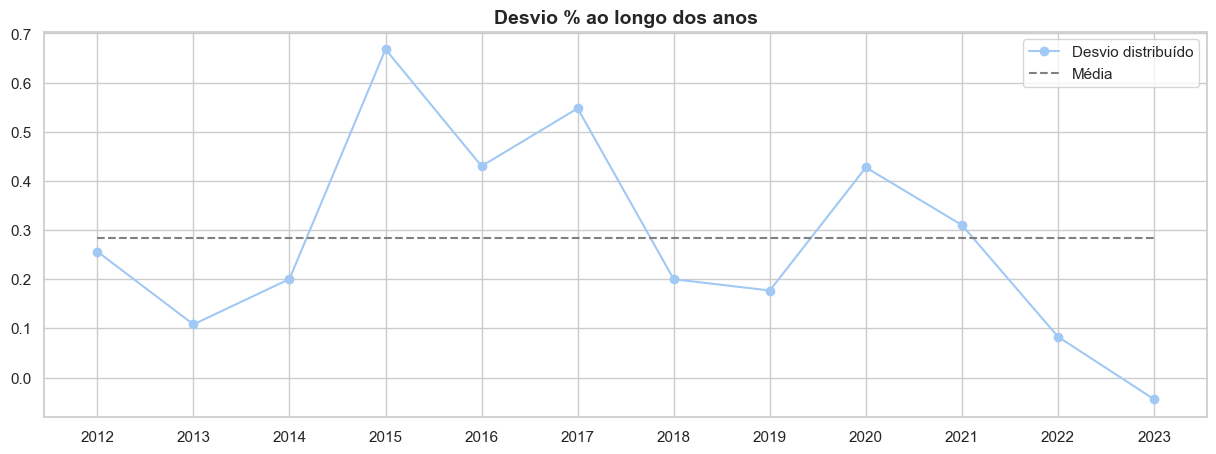

In [47]:
# plota o gráfico com a linha do tempo dos desvios

plt.figure(figsize = [15,5])
plt.plot(df_anos.desvio_ano, marker = 'o', label = 'Desvio distribuído')
plt.hlines(desvio_total, xmin = df_anos.index.min(), xmax = df_anos.index.max(),\
           label = 'Média', linestyle = 'dashed', color = 'gray')
plt.xticks(df_anos.index)
plt.title('Desvio % ao longo dos anos', fontsize=14, fontweight = 'bold')
plt.legend()
plt.show

* Historicamente, o status dos projetos estiveram em déficit em quase a totalidade do período analisado. <br>
* No período entre 2015 e 2017 os desvios ficaram acima da média. É interessante fazer uma averiguação específica deste período para entender melhor o que levou aos desvios.<br>
* Observa-se uma tendência de queda dos desvios desde 2020, sendo que em 2023 o indicador ficou abaixo de zero pela primeira vez. É possível que os dados de 2022 e 2023 ainda seja alterados pelos resultados dos projetos ainda em andamento no ano 2024. Ainda assim, também cabe investigar mais detalhadamento o que pode ter levado a uma melhoria na performance da equipe de projetos neste período. Uma hipótese é mudança de metodologia de projeto mencionada anteriormente.
